In [16]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import joblib
import nltk
import re
import string
import sklearn
import pickle
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from nltk.tokenize import word_tokenize

In [17]:
#reading in the new fold data
df = pd.read_csv('depression_folds.csv')
features = df.drop('kfold', axis=1).columns
pickle.dump(features, open('features.pickle', 'wb'))

In [18]:
df.head()

,depression,text,kfold
0,1,@benj_fry Lysi fish oil for vitamin D against ...,0
1,1,"RT @QistinaFaiqah: During pms, the progesteron...",0
2,1,@infcomment How great is the risk of a second ...,0
3,0,RT @Allnodes: We are happy to announce that #A...,0
4,0,@montanadevy happy birthday,0


### Text Preporcessing

In [19]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = "@[a-z0-9]\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [24]:
def text_preprocess(tweet):
    tweet = tweet.lower()
    #remove hyperlinks
    tweet = re.sub(r"http?:\S+|www\S+|https?:\S+", '', tweet)
    #remove user @ mentions
    tweet = re.sub(r'@[a-z0-9]+','', tweet)
    #remove # symbols
    tweet = re.sub(r'#', '', tweet)
    #remove rt
    tweet = re.sub(r'rt[\s]+', '', tweet)
    #remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    #remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    #word normalization
    stemmer = SnowballStemmer('english')
    #stemmed_words = [stemmer.stem(w) for w in filtered_words]
    #lemmatizer = WordNetLemmatizer()
    stemmed_words = [stemmer.stem(w) for w in filtered_words]
    
    return " ".join(stemmed_words)

In [25]:
token = df.text.apply(lambda x: text_preprocess(x))

In [12]:
pickle.dump(token, open('tokenizer.pickle', 'wb'))

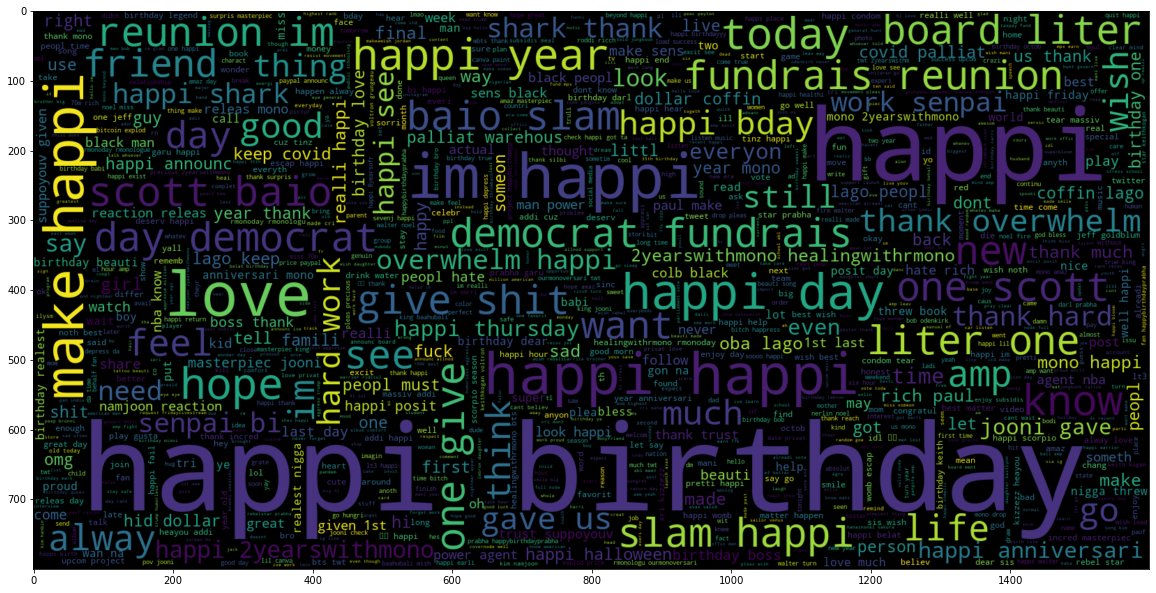

In [9]:
from wordcloud import WordCloud

plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(df[df.depression == 0].text))
plt.imshow(wc, interpolation= 'bilinear')

In [13]:
token

0        fri lysi fish oil vitamin winter depress prefe...
1        pms progesteron hormon help stay calm decrea l...
2        great risk second great depress reelect donald...
3        happi announc allnod suppolaunch avax valid no...
4                                           happi birthday
                               ...                        
19995                           birth control depress real
19996                                              depress
19997    ‘ escap ’ covid19 shadow season depress could ...
19998    break news donald trump caus america biggest e...
19999                        sorri ino b u bet depress dey
Name: text, Length: 20000, dtype: object

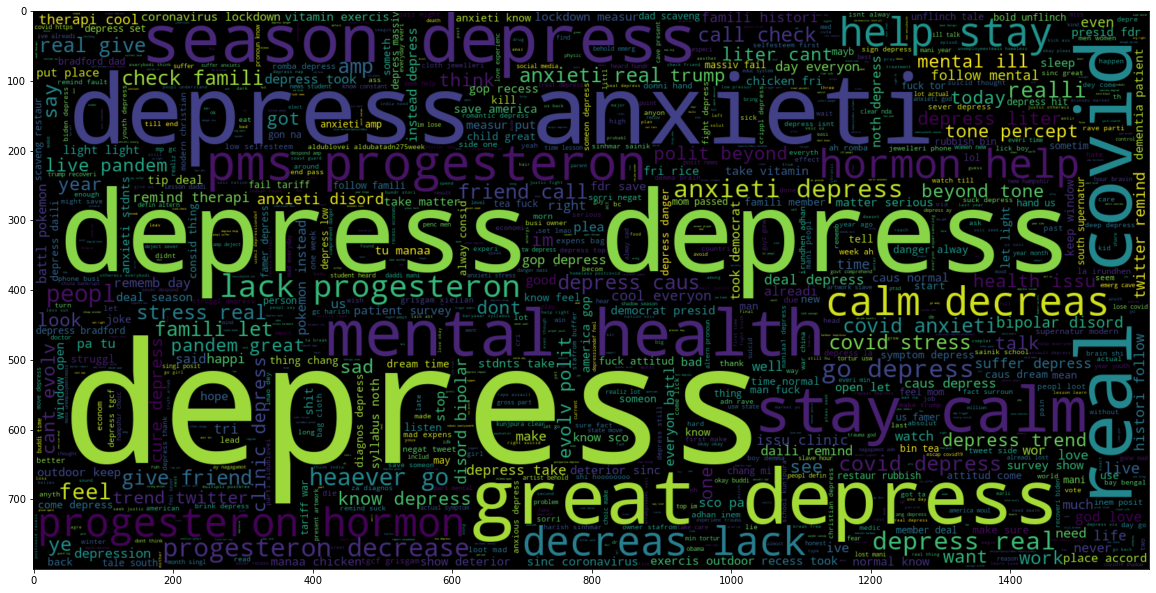

In [10]:
from wordcloud import WordCloud

plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(df[df.depression == 1].text))
plt.imshow(wc, interpolation= 'bilinear')

In [11]:
df.head()

,depression,text,kfold
0,1,fri lysi fish oil vitamin winter depress prefe...,0
1,1,pms progesteron hormon help stay calm decreas ...,0
2,1,great risk second great depress reelect donald...,0
3,0,happi announc allnod support launch avax valid...,0
4,0,happi birthday,0


### MODEL BUILDING

In [26]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer()

In [27]:
tf = tfidf.fit_transform(df['text'])
tf.shape

(20000, 30523)

In [29]:
with open('vectorized_model.pickle', 'wb') as vectorized_file:
    vectorized_model = pickle.dump(tf, vectorized_file)

count_vectorizer = CountVectorizer(stop_words='english')
cv = count_vectorizer.fit_transform(df['text'])
cv.shape

In [30]:
X_train, X_test, y_train, y_test = train_test_split(tf, df['depression'], test_size = 0.2, 
                                                    stratify = df['depression'], random_state=42)

### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.96475

In [33]:
with open('clf_model.pickle', 'wb') as modelFile:
    pickle.dump(clf, modelFile)

In [17]:
y_pred_proba = clf.predict_proba(X_test)[:,1]

In [18]:
roc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)

In [19]:
roc

0.99580775

In [20]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[1930,   70],
       [  74, 1926]], dtype=int64)

In [21]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2000
           1       0.96      0.96      0.96      2000

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



### XGBOOST

In [22]:
from xgboost import XGBClassifier

In [23]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)


In [24]:
y_pred_proba = xgb.predict_proba(X_test)[:,1]

In [25]:
roc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
roc

0.991474875

In [26]:
confusion_m = sklearn.metrics.confusion_matrix(y_test, y_pred)
print(confusion_m)

[[1788  212]
 [  22 1978]]


In [27]:
accuracy_score(y_pred, y_test)

0.9415

### SVM

In [28]:
from sklearn.svm import NuSVC

In [29]:
svc = NuSVC()

In [30]:
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)



In [31]:
accuracy_score(y_pred, y_test)

0.962

In [32]:
confusion_m = sklearn.metrics.confusion_matrix(y_test, y_pred)
print(confusion_m)

[[1933   67]
 [  85 1915]]


### Checking for Overfitting

In [38]:
train_accuracies = [0.5]
test_accuracies = [0.5]

In [33]:
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

In [35]:
from sklearn import metrics

In [39]:
# Calculate training & test accuracies
train_accuracy = metrics.accuracy_score(y_train, train_predictions)
test_accuracy = metrics.accuracy_score(y_test, test_predictions)

# append accuracies
train_accuracies.append(train_accuracy)
test_accuracies.append(test_accuracy)

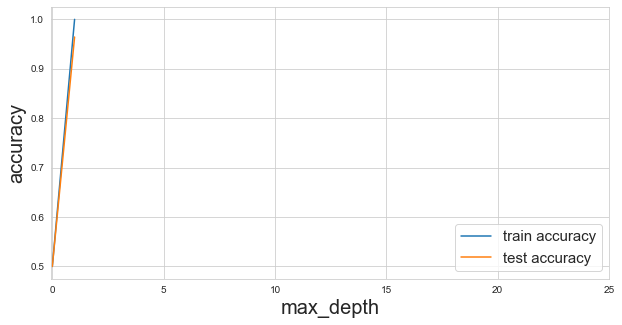

In [41]:
# create two plots using matplotlib
# and seaborn
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.plot(train_accuracies, label="train accuracy")
plt.plot(test_accuracies, label="test accuracy")
plt.legend(loc="lower right", prop={'size': 15})
plt.xticks(range(0, 26, 5))
plt.xlabel("max_depth", size=20)
plt.ylabel("accuracy", size=20)
plt.show()